In [1]:
from simulator_brian import create_connection_matrix
import os
import imp
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
import elephant
import pickle as pkl
from brian2 import *
import pdb
import sys
import pandas as pd

In [2]:
data_path = '/home/jovyan/work/instrumentalVariable/test_data_sim/'
param_module = 'params_test_fast_brian2.py'
os.makedirs(data_path, exist_ok=True)
jobname = param_module.replace('.py', '')
currdir = '/home/jovyan/work/instrumentalVariable/causal-optogenetics-paper-data/'
f, p, d = imp.find_module(jobname, [currdir])
p = imp.load_module(jobname, f, p, d).parameters

### Set neurons


In [3]:
eqs = '''dV_m/dt = (g_L*(E_L-V_m)+Ie+Ii+I+Ix)/(C_m) : volt
         Ie = ge*(E_ex-V_m) : amp
         Ii = gi*(E_in-V_m) : amp
         dge/dt = -ge/(tau_syn_ex) : siemens
         dgi/dt = -gi/(tau_syn_in) : siemens
         Ix = sizes*0.5*(1+sin(2*pi*rates*t)) : amp
         rates : Hz
         sizes : amp
         I : amp'''
nodes = NeuronGroup(
    p['N_neurons'],
    model=eqs,
    threshold='V_m > V_th',
    reset='V_m = V_reset',
    refractory=p['t_ref'],
    namespace=p,
    method='euler',
)

nodes.sizes = p['s_sin']
nodes.rates= p['r_sin']

p['C_ex'] = int(p['eps'] * p['N_ex'])
p['C_in'] = int(p['eps'] * p['N_in'])
n = p['tau_syn_in'] * abs(p['E_L'] - p['E_in'])
d = p['J_ex'] * p['tau_syn_ex'] * abs(p['E_L'] - p['E_ex'])
p['J_in'] = p['g'] * d / n

nodes_ex = nodes[:p['N_ex']]
nodes_in = nodes[p['N_ex']:]

nodes_ex_stim = nodes_ex[:p['stim_N_ex']]

### Set connections from matrix

In [4]:
m = create_connection_matrix(p, p['msd'])

# store connections
with open(str(data_path)+'/'+'m.pkl', 'wb') as f:
            pkl.dump(m, f)

  0%|          | 0/400 [00:00<?, ?it/s]WARNING    /opt/conda/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1025: UserWarning: Unknown ufunc 'clip' in __array_prepare__
  warn("Unknown ufunc '%s' in __array_prepare__" % uf.__name__)
 [py.warnings]
WARNING    /opt/conda/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1060: UserWarning: Unknown ufunc 'clip' in __array_wrap__
  warn("Unknown ufunc '%s' in __array_wrap__" % uf.__name__)
 [py.warnings]
100%|██████████| 400/400 [00:00<00:00, 2867.06it/s]

Finding excitatory and inhibitory projections
J_ex =  0.68 nS C_ex =  32 J_in =  12.852 nS C_in =  8


In [5]:
syn_ex = Synapses(
    nodes_ex,
    nodes,
    model='w:siemens',
    on_pre='ge+=w',
    delay=p['syn_delay'])

syn_in = Synapses(
    nodes_in,
    nodes,
    model='w:siemens',
    on_pre='gi+=w',
    delay=p['syn_delay'])

N_ex = p['N_ex']
j, i = np.where(m)
j_ex, i_ex = j[i<N_ex], i[i<N_ex]
j_in, i_in = j[i>=N_ex], i[i>=N_ex]        

syn_ex.connect(i=i_ex, j=j_ex)
syn_ex.w = m[j_ex, i_ex]

syn_in.connect(i=i_in-N_ex, j=j_in)
syn_in.w = m[j_in, i_in]

### Set background stimulation

In [6]:
poissInp = PoissonInput(
    nodes, 'ge',
    N=p['N_p'],
    rate=p['rate_p'],
    weight=p['J_ex'])

In [7]:
@network_operation(when='end')
#@network_operation
def stop_for_spikes():
#    if len(nodes_ex_stim.spikes):
#    if len(np.in1d(nodes.spikes, nodes_ex_stim_i)):
    # .spikes is not subgroup specific
    # therefore we have to manually check whether any of the occuring spikes
    # is from the subgroup.
    if len(nodes.spikes) and np.searchsorted(nodes.spikes, idx_stop_pl_1)>0:
        stop()

### Set spike monitors

In [8]:
# 1 for times without stim
spk_mon1 = SpikeMonitor(nodes)

# 2 for stimulation periods
spk_mon2 = SpikeMonitor(nodes)
spk_mon2_t = {}
spk_mon2_i = {}
spk_mon2.active = False

### Simulate

In [9]:
#nodes_ex_stim_i = np.array(nodes_ex_stim.i)

# find last index +1 of stim supgroup
idx_stop_pl_1 = nodes_ex_stim.stop
# make sure that stim subgroups starts with 0
assert nodes_ex_stim.start == 0


@network_operation(when='end')
#@network_operation
def stop_for_spikes():
#    if len(nodes_ex_stim.spikes):
#    if len(np.in1d(nodes.spikes, nodes_ex_stim_i)):
    # .spikes is not subgroup specific
    # therefore we have to manually check whether any of the occuring spikes
    # is from the subgroup.
    if len(nodes.spikes) and np.searchsorted(nodes.spikes, idx_stop_pl_1)>0:
        stop()

In [10]:
# run init time without stimulation
stop_for_spikes.active = False
run(p['init_simtime'])
sys.stdout.write('\r'+str(defaultclock.t/ms))
t2 = defaultclock.t/ms

# now with stimulation
stop_for_spikes.active = True
# initialize random dealy time between branching points
t_dist_i = np.random.uniform(p['t_dist_min']/ms, p['t_dist_max']/ms)

run(p['runtime'] - defaultclock.t)

while defaultclock.t < p['runtime']:
    if defaultclock.t/ms - t2 > t_dist_i:
        # stimulation only after init_simtime 
        stop_for_spikes.active = False
        # get timepoint of branching, shift by the delay of 0.1 ms
        t2 = defaultclock.t/ms - 0.1
        t2 = defaultclock.t/ms
        # store network state before stimulation
        store()
        # We'll need an explicit seed here, otherwise we'll continue with different
        # random numbers after the restore
        use_seed = randint(iinfo(np.int32).max)
        seed(use_seed)
        # change spike monitors
        spk_mon1.active = False
        spk_mon2.active = True
        # stimulate
        nodes_ex_stim.I = p['stim_amp_ex']
        run(p['stim_duration'])
        # turn stimuli off, but keep on simulation
        t_left = p['simtime_stim'] - p['stim_duration']
        nodes_ex_stim.I = 0.*pA
        run(t_left)
        # store data of intermittent run
        spk_mon2_t[t2] = np.array(spk_mon2.t/ms)
        spk_mon2_i[t2] = np.array(spk_mon2.i).astype(int)
        # restore previous network state and continue with simulation
        stop_for_spikes.active = True
        restore()
        seed(use_seed)
        spk_mon1.active = True
        spk_mon2.active = False
        sys.stdout.write('\r'+str(defaultclock.t/ms))

        # generate waiting time
        t_dist_i = np.random.uniform(p['t_dist_min']/ms, p['t_dist_max']/ms)
        
    run(p['runtime'] - defaultclock.t)

46.800000000000001

### Store spikes

In [11]:
t1, i1 = np.array(spk_mon1.t), np.array(spk_mon1.i)
with open(str(data_path) + '/' + 'spks1.csv', 'w') as f:
        pd.DataFrame({'t': t1, 'id': i1.astype(int)}
        ).to_csv(f, header=False, index=False)

In [12]:
data = {
    'spk_ids': spk_mon2_i,
    'spk_ts': spk_mon2_t,
    'nodes_ex_stim': np.array(nodes_ex_stim.i)}
np.savez(data_path + 'stimulation_data.npz', data=data)

### Visualize spikes

(0.01, 0.05)

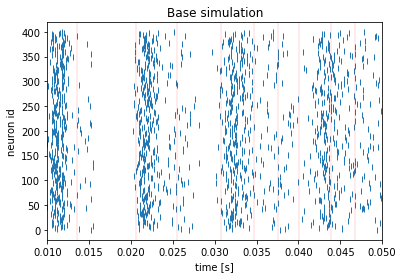

In [13]:
fig, ax = plt.subplots(1)
ax.plot(spk_mon1.t/second, spk_mon1.i, '|')
ax.set_title('Base simulation')
ax.set_xlabel('time [s]')
ax.set_ylabel('neuron id')

# visualize also branching points
br_points = np.array(list(spk_mon2_i.keys()))/1000
a=[ax.axvline(x, c='r', alpha=0.1) for x in br_points]

ax.set_xlim(0.01, 0.05)

Text(0, 0.5, 'neuron id')

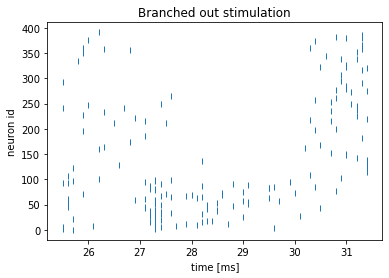

In [21]:
t_sel = br_points[-7]*1000
fig, ax = plt.subplots(1)
ax.plot(spk_mon2_t[t_sel], spk_mon2_i[t_sel], '|')
ax.set_title('Branched out stimulation')
ax.set_xlabel('time [ms]')
ax.set_ylabel('neuron id')